## Introduction
The task is to forecast daily Wikipedia pageviews for the 'Figma (software)' page from today until mid-next year. The dataset spans from January 2015 to today and exhibits weekly seasonality and structural breaks in traffic. The goal is to build a reliable forecasting model, justify the methodology, and present interpretable results.

##Load and Explore Full Dataset (2022–2025)
I began by importing the dataset containing daily Wikipedia pageviews for the Figma article. This data spans from January 2022 through May 2025. The goal is to forecast future pageviews based on patterns in this historical data. Initially, I will explore the full dataset to understand trends, seasonality, and anomalies that may influence model design.

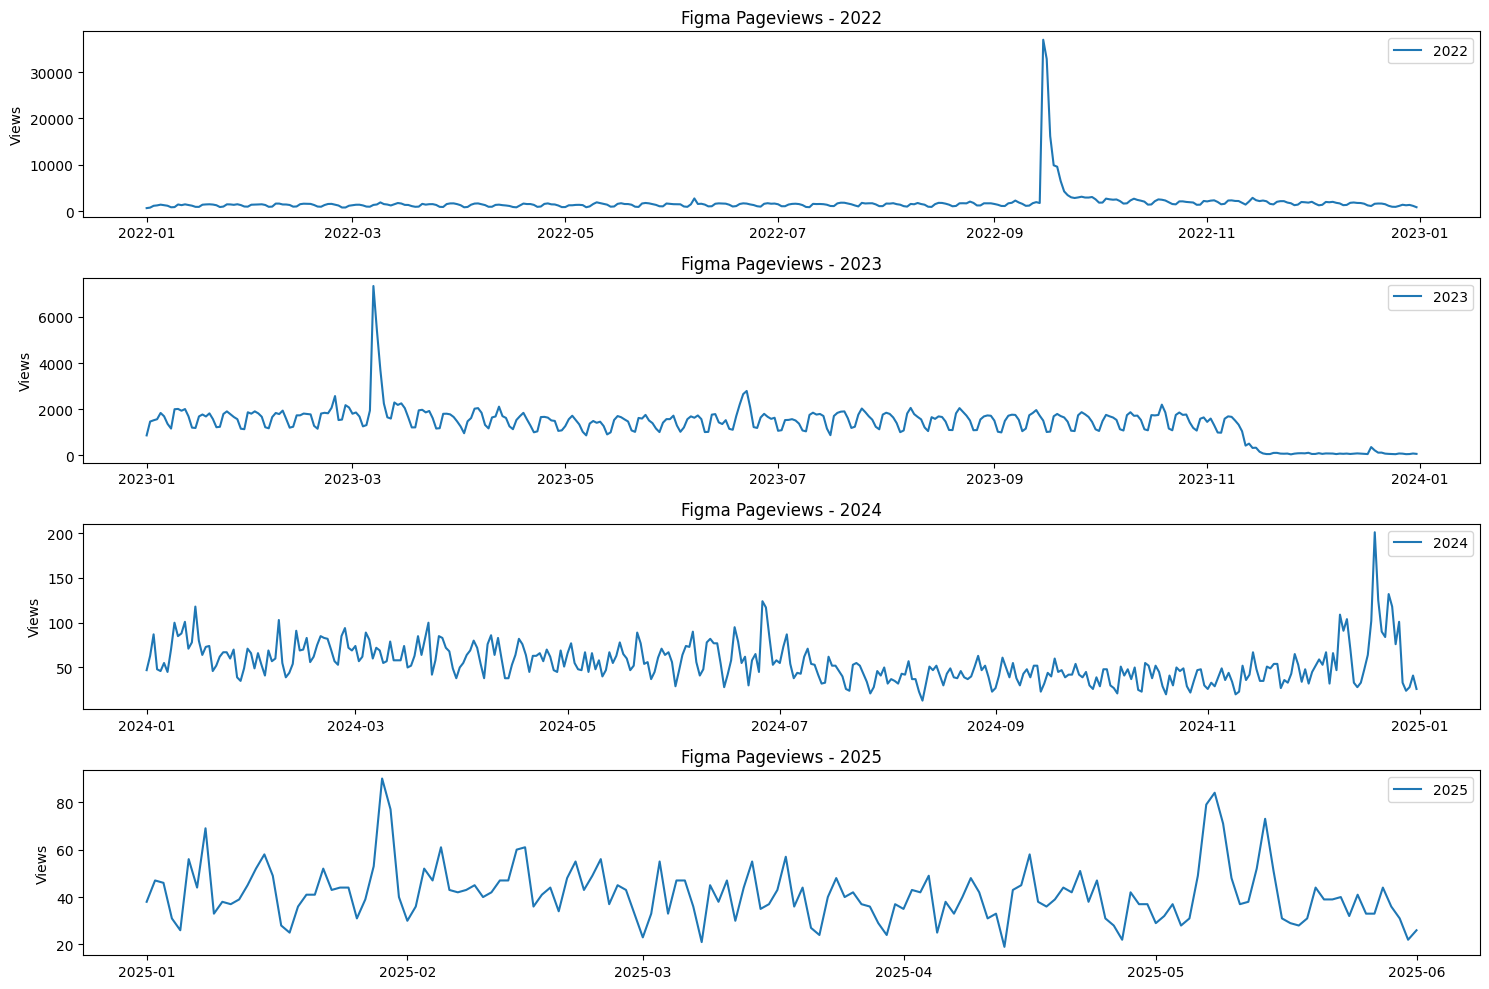

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# 1. Load the data
df = pd.read_csv("/content/pageviews-20220101-20250601.csv", parse_dates=["Date"])


# 2. Extract year
df['year'] = df['Date'].dt.year

# 3. Plot year-wise pageviews
years = sorted(df['year'].unique())
plt.figure(figsize=(15, 10))

for i, year in enumerate(years, 1):
    plt.subplot(len(years), 1, i)
    subset = df[df['year'] == year]
    sns.lineplot(data=subset, x='Date', y='Figma (software)', label=str(year))
    plt.title(f"Figma Pageviews - {year}")
    plt.xlabel("")
    plt.ylabel("Views")

plt.tight_layout()
plt.show()



In [62]:
#Summary statistics by year

yearly_summary = df.groupby('year')['Figma (software)'].agg(['mean', 'median', 'std', 'max', 'min', 'count']).reset_index()
print(yearly_summary)

   year         mean  median          std    max  min  count
0  2022  1794.583562  1465.0  2708.169478  36996  632    365
1  2023  1380.010959  1534.0   708.257970   7341   36    365
2  2024    55.390710    52.0    21.684862    201   13    366
3  2025    41.552632    40.0    11.938468     90   19    152


On the bais of above analysis of the full time series, we can observe a significant **drop in traffic around late 2023**, marking a structural shift in the data. To ensure stationarity and modeling stability, I choose to model **only the post-2024 data**, which exhibits a more consistent behavior.

# Subset from 2024 Onward & Apply Log Transformation
 I have used a subset of the data from January 2024 onward. A `log1p` transformation is applied to stabilize variance and handle skewed distributions due to traffic spikes. This also prepares the data for statistical modeling.

In [63]:
# Subset from 2024 onward
df.drop("year", inplace = True, axis = 1)
df.set_index("Date", inplace=True)
df_2024 = df["2024-01-01":].copy()

# Check shape and preview
df_2024.shape, df_2024.head()

((518, 1),
             Figma (software)
 Date                        
 2024-01-01                47
 2024-01-02                63
 2024-01-03                87
 2024-01-04                48
 2024-01-05                46)

In [64]:
df_2024.describe()

,Figma (software)
count,518.000000
mean,51.330116
std,20.331991
min,13.000000
25%,38.000000
50%,47.000000
75%,62.000000
max,201.000000


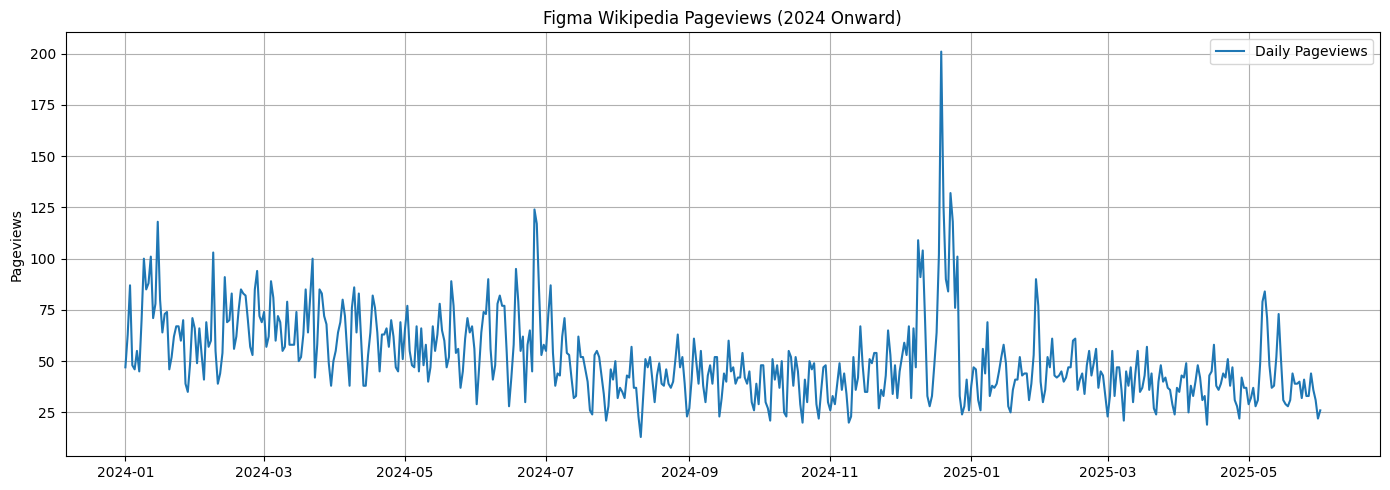

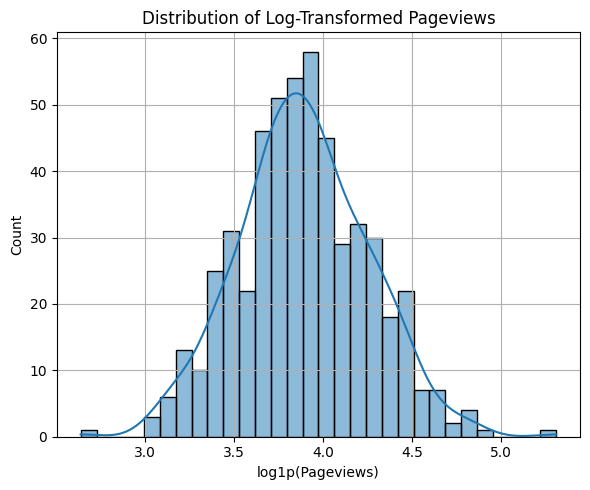

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting raw pageviews from 2024 onward
plt.figure(figsize=(14, 5))
plt.plot(df_2024, label="Daily Pageviews")
plt.title("Figma Wikipedia Pageviews (2024 Onward)")
plt.ylabel("Pageviews")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Applying log1p transformation to stabilize variance
df_2024["log_views"] = np.log1p(df_2024["Figma (software)"])

# Visualize distribution of transformed data
plt.figure(figsize=(6, 5))
sns.histplot(df_2024["log_views"], bins=30, kde=True)
plt.title("Distribution of Log-Transformed Pageviews")
plt.xlabel("log1p(Pageviews)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Stationarity Check using ADF Test
The **Augmented Dickey-Fuller (ADF) test** is used to assess whether the time series is stationary.

- If p-value > 0.05: non-stationary
- If p-value < 0.05: stationary

I have applied first-order differencing (`d=1`) to make the series stationary.

In [66]:
# ADF test on log-transformed data from 2024 onward
adf_result_fresh = adfuller(df_2024["log_views"])
adf_statistic_fresh, p_value_fresh = adf_result_fresh[0], adf_result_fresh[1]

# Apply first-order differencing
df_log_diff_fresh = df_2024["log_views"].diff().dropna()

# ADF test on differenced series
adf_diff_result_fresh = adfuller(df_log_diff_fresh)
adf_diff_stat_fresh, p_diff_val_fresh = adf_diff_result_fresh[0], adf_diff_result_fresh[1]

(adf_statistic_fresh, p_value_fresh), (adf_diff_stat_fresh, p_diff_val_fresh)


((np.float64(-2.5755305522912244), np.float64(0.09816079586995874)),
 (np.float64(-8.5543704308448), np.float64(9.042583630815206e-14)))

## ACF and PACF Plots for Model Order Selection
Using **ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)** plots on the differenced log series to determine the ARIMA parameters:

- ACF helps choose `q` (MA order)
- PACF helps choose `p` (AR order)

Based on the plots:
- ACF shows strong lag-1 correlation → `q=1`
- PACF cuts off at lag-1 → `p=1`
- Differencing → `d=1`

Also on the basis of ACF plot we can say the data has weekly seasonality as there are spike at lags that are multiples of the season length (7).

Thus, for seasonality (weekly cycles), I will add seasonal order `(P=1, D=0, Q=1, s=7)`

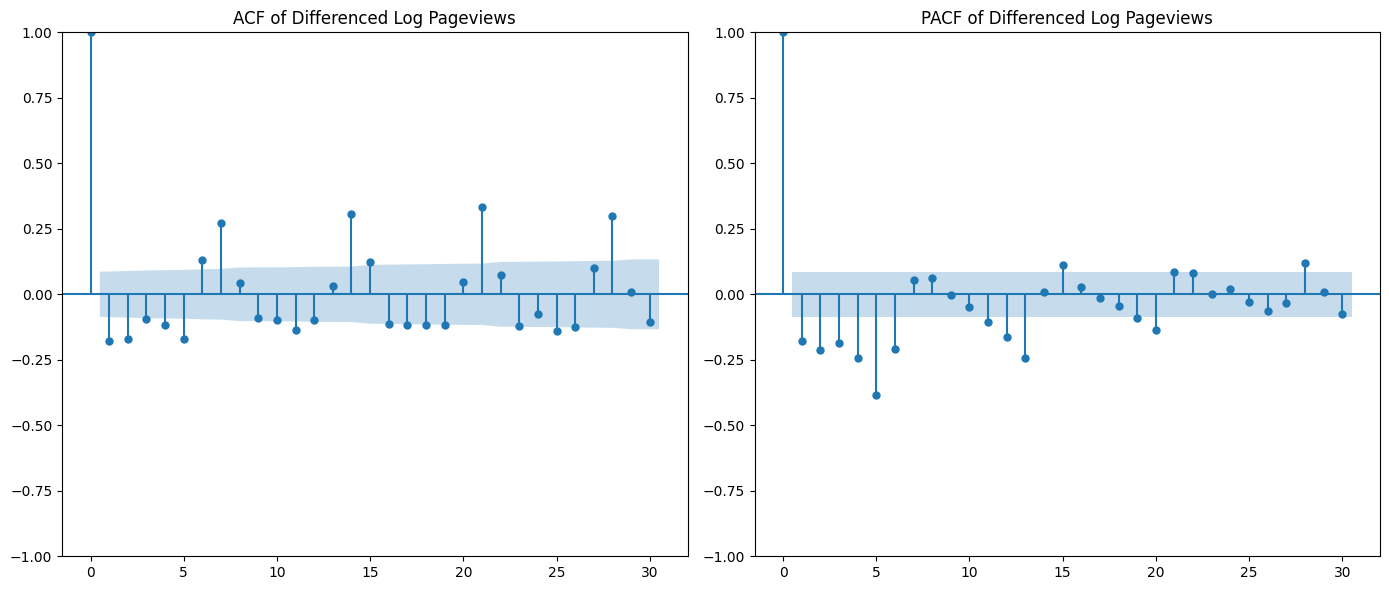

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF on first-differenced log-transformed series
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(df_log_diff_fresh, lags=30, ax=plt.gca())
plt.title("ACF of Differenced Log Pageviews")

plt.subplot(1, 2, 2)
plot_pacf(df_log_diff_fresh, lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF of Differenced Log Pageviews")

plt.tight_layout()
plt.show()


# Model Selection
For this task, I selected the Seasonal ARIMA (SARIMA) model as the primary forecasting approach, based on the following considerations:

1. Clear Seasonality and Trend
The Wikipedia pageviews data for Figma displays strong weekly seasonality, as well as a mild upward trend.

2. Interpretability
Unlike black-box models (e.g., LSTMs), SARIMA provides interpretable parameters:

  * AR (Autoregression): dependence on past values

  * I (Integration): differencing for stationarity

  * MA (Moving Average): dependence on past forecast errors

  * Seasonal counterparts capture weekly periodicity

3. Data Characteristics
A significant structural shift in pageviews is observed post-2023. To maintain model stability and relevance, only data from 2024 onward (stationary segment) was used — SARIMA handles this well once stationarity is enforced.


4. Simplicity and Reproducibility
SARIMA is easy to deploy, validate, and reproduce using standard libraries (statsmodels).

Its parameter selection is guided by statistical tools like ADF tests, ACF/PACF plots, and model diagnostics.



## Fitting a **Seasonal ARIMA** model using the following parameters:

- `order=(1, 1, 1)` from ACF/PACF and ADF test
- `seasonal_order=(1, 0, 1, 7)` for weekly seasonality
- `log_views` is the input (not yet inverse transformed)

This model captures short-term dependencies and seasonal cycles.

In [73]:
# Evaluating model on last 3 months using MAE and RMSE metrics

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split log-transformed data into train/test sets
train = df_2024['log_views'].iloc[:-90]
test = df_2024['log_views'].iloc[-90:]

# Fit SARIMA model on training set
model_eval = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 7),
                     enforce_stationarity=True, enforce_invertibility=True)
results_eval = model_eval.fit(disp=False)

# Forecast the test period
forecast_eval = results_eval.get_forecast(steps=len(test))
predicted_log = forecast_eval.predicted_mean

# Evaluate in original scale (after inverting log1p)
y_true = np.expm1(test)
y_pred = np.expm1(predicted_log)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 8.47
RMSE: 10.71


Thus, model is perfomring well conisdeiring the mterics and hence now we will train the model on complete range of data and forecast till mid of next year.

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model with chosen parameters
sarima_model = SARIMAX(
    df_2024["log_views"],
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=True,
    enforce_invertibility=True
)

sarima_results = sarima_model.fit(disp=False)

from datetime import datetime, date

# function to get number of days from today till mid of next year
def days_until_mid_next_year():
    today = date.today()
    next_year = today.year + 1
    target_date = date(next_year, 6, 30)
    delta = target_date - today
    return delta.days

# Generate forecast for mid of next year
forecast_steps = days_until_mid_next_year() # 393
sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df_2024.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Create forecast DataFrame (log scale first)
forecast_df_log = pd.DataFrame({
    "Forecast_log": sarima_forecast.predicted_mean,
    "Lower_log": sarima_forecast.conf_int().iloc[:, 0],
    "Upper_log": sarima_forecast.conf_int().iloc[:, 1]
}, index=forecast_index)

# Inverse the log1p to get back to original scale
forecast_df = pd.DataFrame({
    "Forecast": np.expm1(forecast_df_log["Forecast_log"]).round().astype(int),
    "Lower CI": np.expm1(forecast_df_log["Lower_log"]).round().astype(int),
    "Upper CI": np.expm1(forecast_df_log["Upper_log"]).round().astype(int)
}, index=forecast_index)

# Save forecast to CSV with date as index
forecast_df.to_csv("figma_sarima_forecast_mid_next_year.csv", index_label="Date")




/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## Plot Forecast vs Actuals
The final plot shows the last 100 days of actuals alongside the forecasted pageviews. The forecast captures seasonal trends and provides a realistic forward projection with uncertainty bounds.

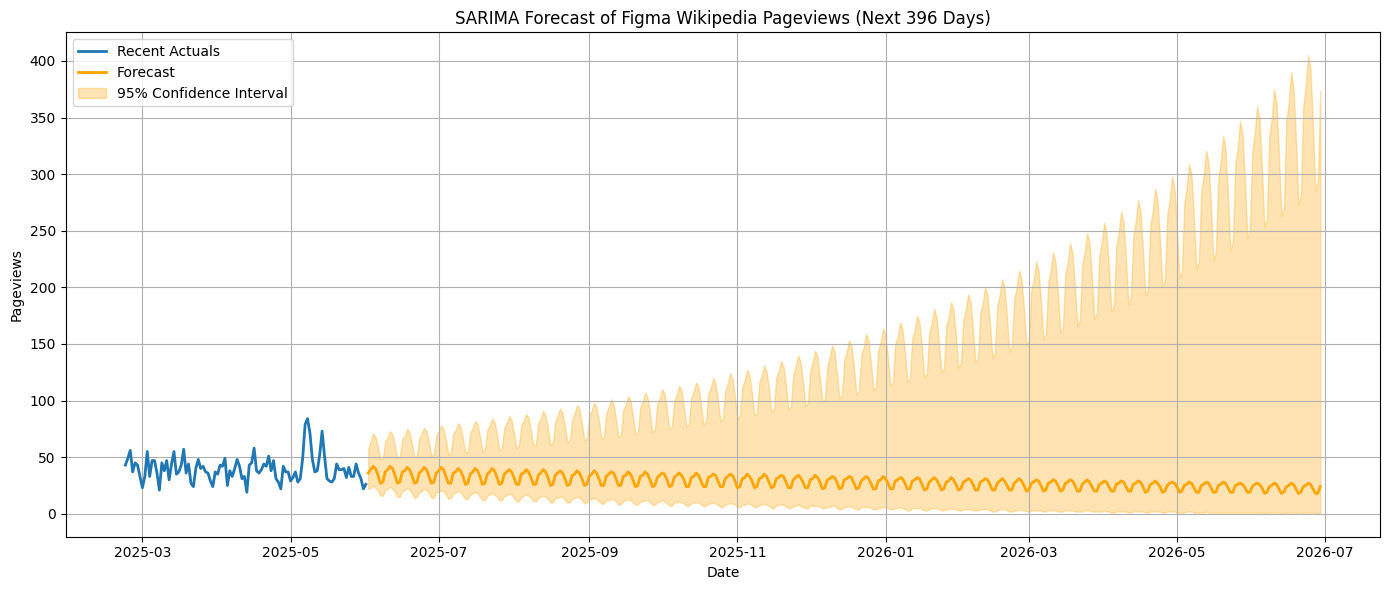

In [70]:
import matplotlib.pyplot as plt

# Plot forecast vs actuals
plt.figure(figsize=(14, 6))

# Plot last 100 days of actual pageviews
plt.plot(df_2024.index[-100:], df_2024["Figma (software)"].iloc[-100:], label="Recent Actuals", linewidth=2)

# Plot forecast
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast", color="orange", linewidth=2)

# Plot confidence intervals
plt.fill_between(forecast_df.index, forecast_df["Lower CI"], forecast_df["Upper CI"],
                 color="orange", alpha=0.3, label="95% Confidence Interval")

# Labels and formatting
plt.title("SARIMA Forecast of Figma Wikipedia Pageviews (Next 396 Days)")
plt.xlabel("Date")
plt.ylabel("Pageviews")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Output
Output file drive link: https://drive.google.com/file/d/1zTo9rzLpL5H0iyrYLNCC_WA1cMHhqxSF/view?usp=sharing

In [71]:
forecast_df = pd.read_csv("/content/figma_sarima_forecast_mid_next_year.csv", index_col="Date")
forecast_df.head()

,Forecast,Lower CI,Upper CI
Date,,,
2025-06-02,36,22,58
2025-06-03,39,23,64
2025-06-04,42,25,71
2025-06-05,40,23,68
2025-06-06,34,20,59


##Final Observations:
* Seasonality is captured nicely (weekly oscillation).

* Forecast remains stable initially but shows gradual upward drift.

* Confidence intervals widen significantly over time — typical of SARIMA but something to monitor.

